In [8]:
import json
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
class TACOSMetadataAnalyzer:
    def __init__(self, metadata_path):
        """
        parent class wt=ith functions to analyse the metadata of TACOS dataset
        """
        self.metadata_path = Path(metadata_path)
        self.works_data = None
        # Dictionary to store organized cover relationships
        self.cover_relationships = {}

    def load_metadata(self):
        """
        Load the metadata JSON file and organize it into cover relationships.
        The file structure has works (original songs) containing multiple performances (versions).
        """
        try:
            with open(self.metadata_path, "r", encoding="utf-8") as f:
                self.works_data = json.load(f)

            # Process each work (original song) and its performances (versions)
            for work_id, performances in self.works_data.items():
                # Get the first performance to extract work (original song) information
                first_perf = next(iter(performances.values()))

                self.cover_relationships[work_id] = {"work_title": first_perf["work_title"], "work_artist": first_perf["work_artist"], "performances": []}

                # Add all performances (including different versions)
                for perf_id, perf_data in performances.items():
                    performance = {
                        "title": perf_data["perf_title"],
                        "artist": perf_data["perf_artist"],
                        "year": perf_data.get("release_year", "Unknown"),
                        "performance_id": perf_id,
                        "instrumental": perf_data.get("instrumental", "Unknown"),
                    }
                    self.cover_relationships[work_id]["performances"].append(performance)

                # Add count of covers
                self.cover_relationships[work_id]["number_of_covers"] = len(performances)

            return True

        except Exception as e:
            print(f"Error loading metadata: {str(e)}")
            return False

    def save_cover_relationships(self, output_file="cover_relationships.txt", min_covers=1):
        """
        Save organized information about each work and its covers to a file.
        """

        if not self.cover_relationships:
            print("No data loaded. Please run load_metadata() first.")
            return

        with open(output_file, "w", encoding="utf-8") as f:
            f.write(f"\nFound {len(self.cover_relationships)} works with performances:\n")
            f.write("=" * 80 + "\n")

            for work_id, work_info in self.cover_relationships.items():
                if work_info["number_of_covers"] >= min_covers:
                    f.write(f"\nOriginal Work: {work_info['work_title']}\n")
                    f.write(f"Original Artist: {work_info['work_artist']}\n")
                    f.write(f"Number of covers: {work_info['number_of_covers']}\n")

                    f.write("\nPerformances:\n")
                    for idx, perf in enumerate(work_info["performances"], 1):
                        f.write(f"{idx}. '{perf['title']}' by {perf['artist']} ({perf['year']})\n")
                        f.write(f"   Instrumental: {perf['instrumental']}\n")
                    f.write("-" * 80 + "\n")

        print(f"Cover relationships saved to {output_file}")

    def get_statistics(self):
        """
        Calculate and return statistics about the dataset.
        """
        if not self.cover_relationships:
            return None

        stats = {
            "total_works": len(self.cover_relationships),
            "total_performances": sum(len(work["performances"]) for work in self.cover_relationships.values()),
            "works_with_covers": sum(1 for work in self.cover_relationships.values() if work["number_of_covers"] > 0),
            "most_covered": sorted([(work["work_title"], work["number_of_covers"]) for work in self.cover_relationships.values()], key=lambda x: x[1], reverse=True)[:5],
            "instrumental_count": sum(sum(1 for perf in work["performances"] if perf["instrumental"] == "Yes") for work in self.cover_relationships.values()),
        }

        # Calculate average covers per work
        stats["avg_covers_per_work"] = (stats["total_performances"] - stats["total_works"]) / stats["total_works"]

        return stats

    def find_work_by_artist(self, artist_name):
        """
        Find all works performed by a specific artist.
        """
        found_works = []
        for work_id, work_info in self.cover_relationships.items():
            # Check original artist
            if artist_name.lower() in work_info["work_artist"].lower():
                found_works.append({"work_title": work_info["work_title"], "role": "original artist", "number_of_covers": work_info["number_of_covers"]})

            # Check cover artists
            for perf in work_info["performances"]:
                if artist_name.lower() in perf["artist"].lower():
                    if perf["artist"].lower() != work_info["work_artist"].lower():
                        found_works.append({"work_title": work_info["work_title"], "role": "cover artist", "year": perf["year"], "original_artist": work_info["work_artist"]})

        return found_works

    def plot_covers_distribution(self):
        """
        Creates a histogram showing the distribution of how many songs have a certain number of covers.
        """

        covers_per_work = [work["number_of_covers"] for work in self.cover_relationships.values()]

        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")

        # Create the histogram
        plt.hist(covers_per_work, bins="auto", edgecolor="black", alpha=0.7)
        plt.xlabel("Number of Covers", fontsize=12)
        plt.ylabel("Number of Original Works", fontsize=12)
        plt.title("Distribution of Covers per Original Work", fontsize=14, pad=20)

        # statistical annotations
        avg_covers = sum(covers_per_work) / len(covers_per_work)
        max_covers = max(covers_per_work)
        stats_text = f"Total Works: {len(covers_per_work)}\n" f"Average Covers: {avg_covers:.1f}\n" f"Maximum Covers: {max_covers}"

        plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment="top", horizontalalignment="right", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
        plt.tight_layout()
        plt.show()

        # Print additional insights about the distribution
        print("\nDistribution Insights:")
        print(f"Most common: {max(set(covers_per_work), key=covers_per_work.count)} covers")
        print(f"Number of works with no covers: " f"{sum(1 for x in covers_per_work if x == 0)}")
        print(f"Number of works with 5+ covers: " f"{sum(1 for x in covers_per_work if x >= 5)}")

    def create_cover_key_mapping(self):
        """
        Creates a mapping of work ids and performance ids
        """
        if not self.works_data:
            print("No data loaded. Please run load_metadata() first.")
            return None

        cover_key_mapping = {}
        for work_id, performances in self.works_data.items():
            # Get the first performance (original version)
            first_perf_id = min(performances.keys())
            # Get all cover performance IDs (excluding the original)
            cover_perf_ids = [pid for pid in performances.keys() if pid != first_perf_id]

            # Only include works that have at least one cover
            if cover_perf_ids:
                cover_key_mapping[work_id] = cover_perf_ids

        return cover_key_mapping

In [10]:
analyzer = TACOSMetadataAnalyzer(r"D:\TACOS\da-tacos_metadata\da-tacos_metadata\da-tacos_benchmark_subset_metadata.json")
analyzer.load_metadata()
analyzer.save_cover_relationships(min_covers=1)

Cover relationships saved to cover_relationships.txt


In [11]:
from pprint import pprint


stats = analyzer.get_statistics()

pprint(stats)

{'avg_covers_per_work': 4.0,
 'instrumental_count': 3243,
 'most_covered': [('Under the Bridge', 13),
                  ('Take Me to Church', 13),
                  ('I Am a Rock', 13),
                  ('Where Is My Mind?', 13),
                  ("I Can't Help It", 13)],
 'total_performances': 15000,
 'total_works': 3000,
 'works_with_covers': 3000}


In [12]:
artist_works = analyzer.find_work_by_artist("Flea")
pprint(artist_works)

[{'number_of_covers': 13,
  'role': 'original artist',
  'work_title': 'Under the Bridge'},
 {'original_artist': 'Bobbie Gentry',
  'role': 'cover artist',
  'work_title': 'Ode to Billie Joe',
  'year': '1968'}]


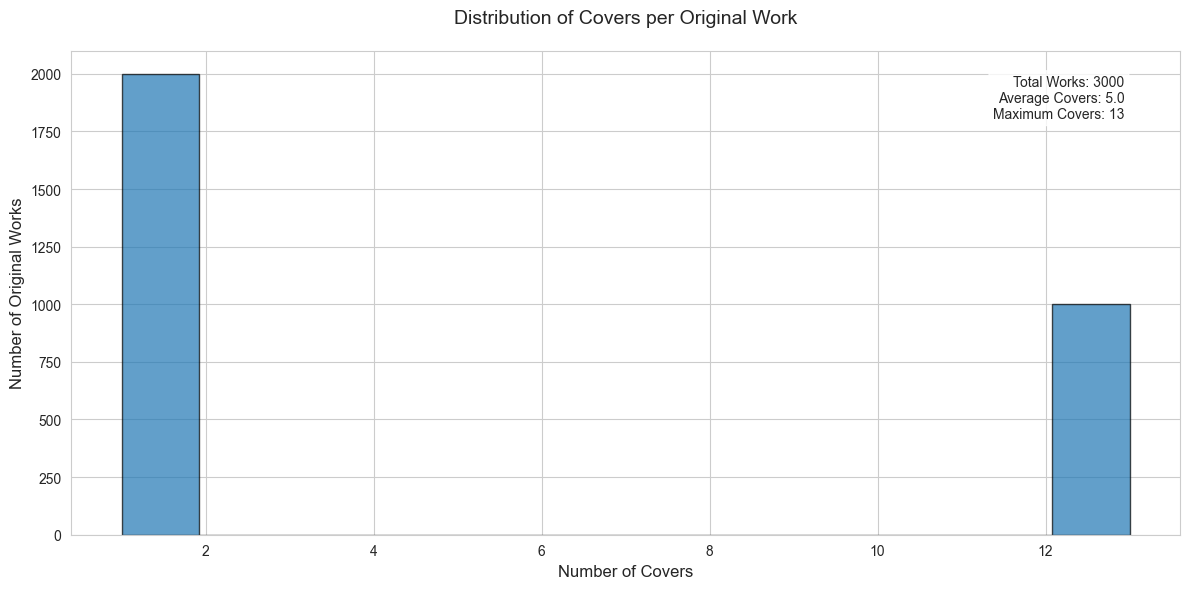


Distribution Insights:
Most common: 1 covers
Number of works with no covers: 0
Number of works with 5+ covers: 1000


In [13]:
analyzer.plot_covers_distribution()

In [14]:
cover_mapping = analyzer.create_cover_key_mapping()
with open("cover_mapping.json", "w") as outfile:
    json.dump(cover_mapping, outfile, indent=4)